# spaCodEx: Clustering

After preprocessing the single cell data, the next step is to assign cell types. One of the most common approaches to identify cell types is unsupervised or semi-unsupervised clustering. scCODEX utilizes the widely used scanpy library to carry out this task. The user can specify different clustering resolutions as well as the number of nearest neighbors to modify the number of identified clusters. The flexible design of scCODEX allows for the selection of unique clustering strategies, dependent on the research question and available dataset. 

## Set up environment

In [1]:
# silencing warnings
import warnings
warnings.filterwarnings('ignore')

#import standard packages
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import scipy as sp
import numpy as np

data_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/' # where the data is stored
code_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/pipeline_test_112023/src' # current where the code is stored, this will be replaced by pip install soon
output_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/output_112023/' #where you want to store the output

if not os.path.exists(output_dir): # check if output path exist - if not generate the path
    os.makedirs(output_dir)
    
sys.path.append(code_dir) 

from helperfunctions_hf import * # Helper functions - used by other functions to execute steps like table formatting etc. KEY: hf
from preprocessing_pp import * # Preprocessing functions - to normalize and prepare data for further analysis KEY: pp
from tools_tl import * # tools - perform calculation on the data KEY: tl
from plot_pl import * # plotting functions - used to visualize results KEY: pl

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
# Loading the denoise/filtered anndata from notebook 2
adata = sc.read(output_dir + 'adata_nn_demo.h5ad')
adata

AnnData object with n_obs × n_vars = 50065 × 58
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'region', 'unique_region', 'condition'

## 3.1 Clustering

In [3]:
# This step can be long if you have large phenocycler images

# Use this cell-type specific markers for cell type annotation
marker_list = ['FoxP3', 'HLA-DR', 'EGFR', 'CD206', 'BCL2', 'panCK', 'CD11b', 'CD56', 'CD163', 'CD21', 'CD8', 
                      'Vimentin', 'CCR7', 'CD57', 'CD34', 'CD31', 'CXCR5', 'CD3', 'CD38', 'LAG3', 'CD25', 'CD16', 'CLEC9A', 'CD11c', 
                      'CD68', 'aSMA', 'CD20', 'CD4','Podoplanin', 'CD15', 'betaCatenin', 'PAX5', 
                      'MCT', 'CD138', 'GranzymeB', 'IDO-1', 'CD45', 'CollagenIV', 'Arginase-1']

# clustering
adata = tl_clustering(adata, 
              clustering='leiden', # can choose between leiden and louvian
              n_neighbors=10,
              resolution = 0.4, #clustering resolution
              reclustering = False, # if true, no computing the neighbors
              marker_list = marker_list #if it is None, all variable names are used for clustering
              ) 

Computing neighbors and UMAP


2023-11-28 17:55:24.831498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Clustering


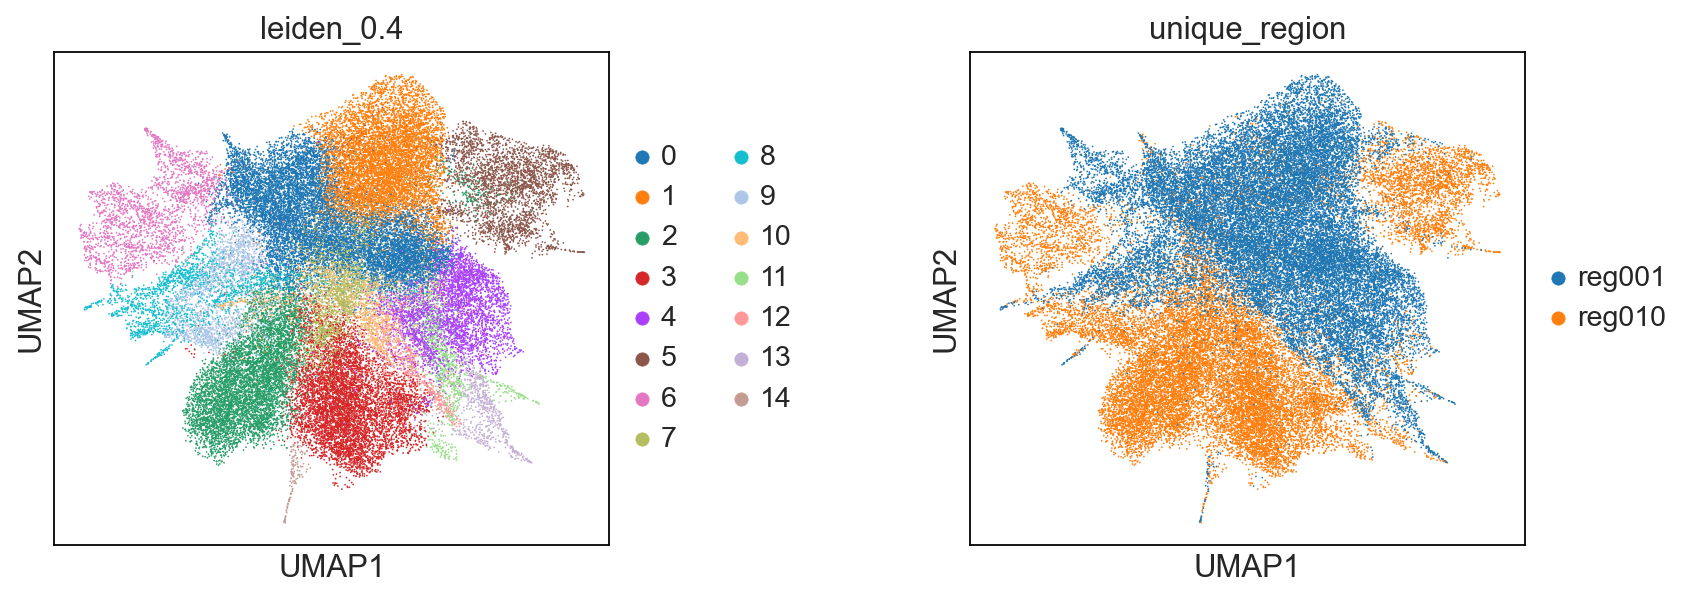

In [4]:
# visualization of clustering with UMAP
sc.pl.umap(adata, color = ['leiden_0.4', 'unique_region'], wspace=0.5) 

         Falling back to preprocessing with `sc.pp.pca` and default params.


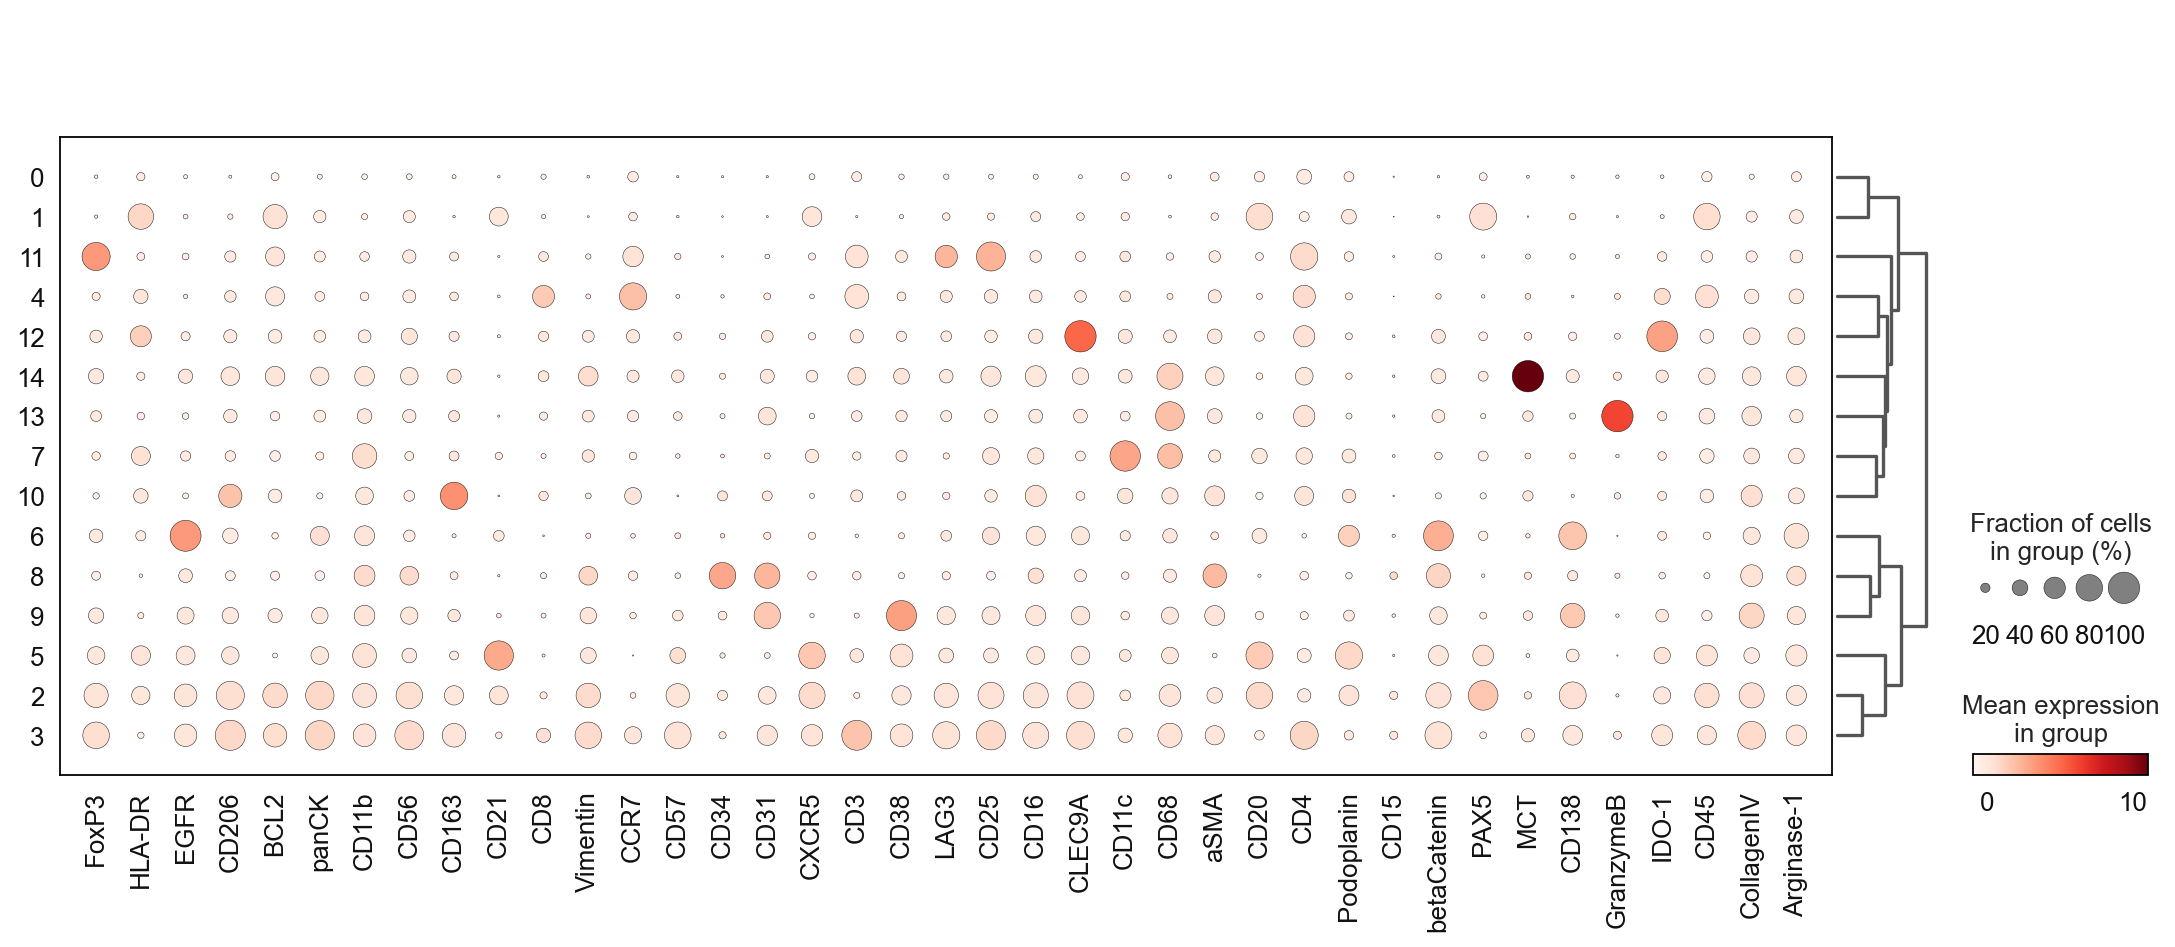

In [5]:
sc.pl.dotplot(adata, marker_list, 'leiden_0.4', dendrogram = True)

In [6]:
# tentative annotation based on the marker 
cluster_to_ct_dict = {
    '0': 'B_CD4_vessel_mix', # *further subcluster
    '1': 'B',
    '2': 'B', # *DC candidate
    '3': 'CD4_CD8T_mix', # *further subcluster
    '4': 'CD4_CD8T_mix', # *further subcluster
    '5': 'GCB',
    '6': 'epithelia',
    '7': 'DC',
    '8': 'Vessel',
    '9': 'Plasma',
    '10': 'M2',
    '11': 'CD4T', # * Treg candidate 
    '12': 'cDC1',
    '13': 'M1',
    '14': 'Mast cell'
}

## 3.3 Sub-clustering (optional)

### round 1 subclustering

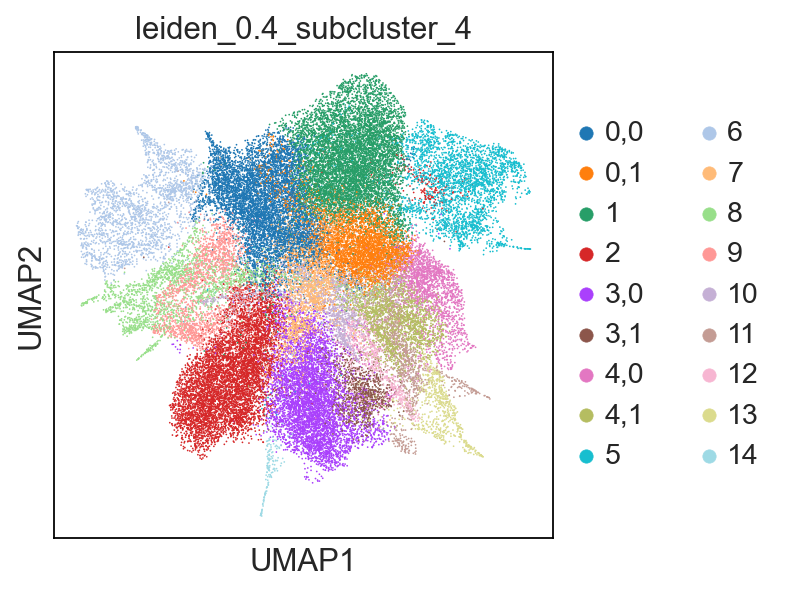

In [7]:
# subclustering cluster 0, 3, 4 sequentially (could be optional for your own data)
sc.tl.leiden(adata, restrict_to=('leiden_0.4',['0']), resolution=0.15, key_added='leiden_0.4_subcluster_0')
sc.tl.leiden(adata, restrict_to=('leiden_0.4_subcluster_0',['3']), resolution=0.1, key_added='leiden_0.4_subcluster_3')
sc.tl.leiden(adata, restrict_to=('leiden_0.4_subcluster_3',['4']), resolution=0.1, key_added='leiden_0.4_subcluster_4')
sc.pl.umap(adata, color = ['leiden_0.4_subcluster_4'])

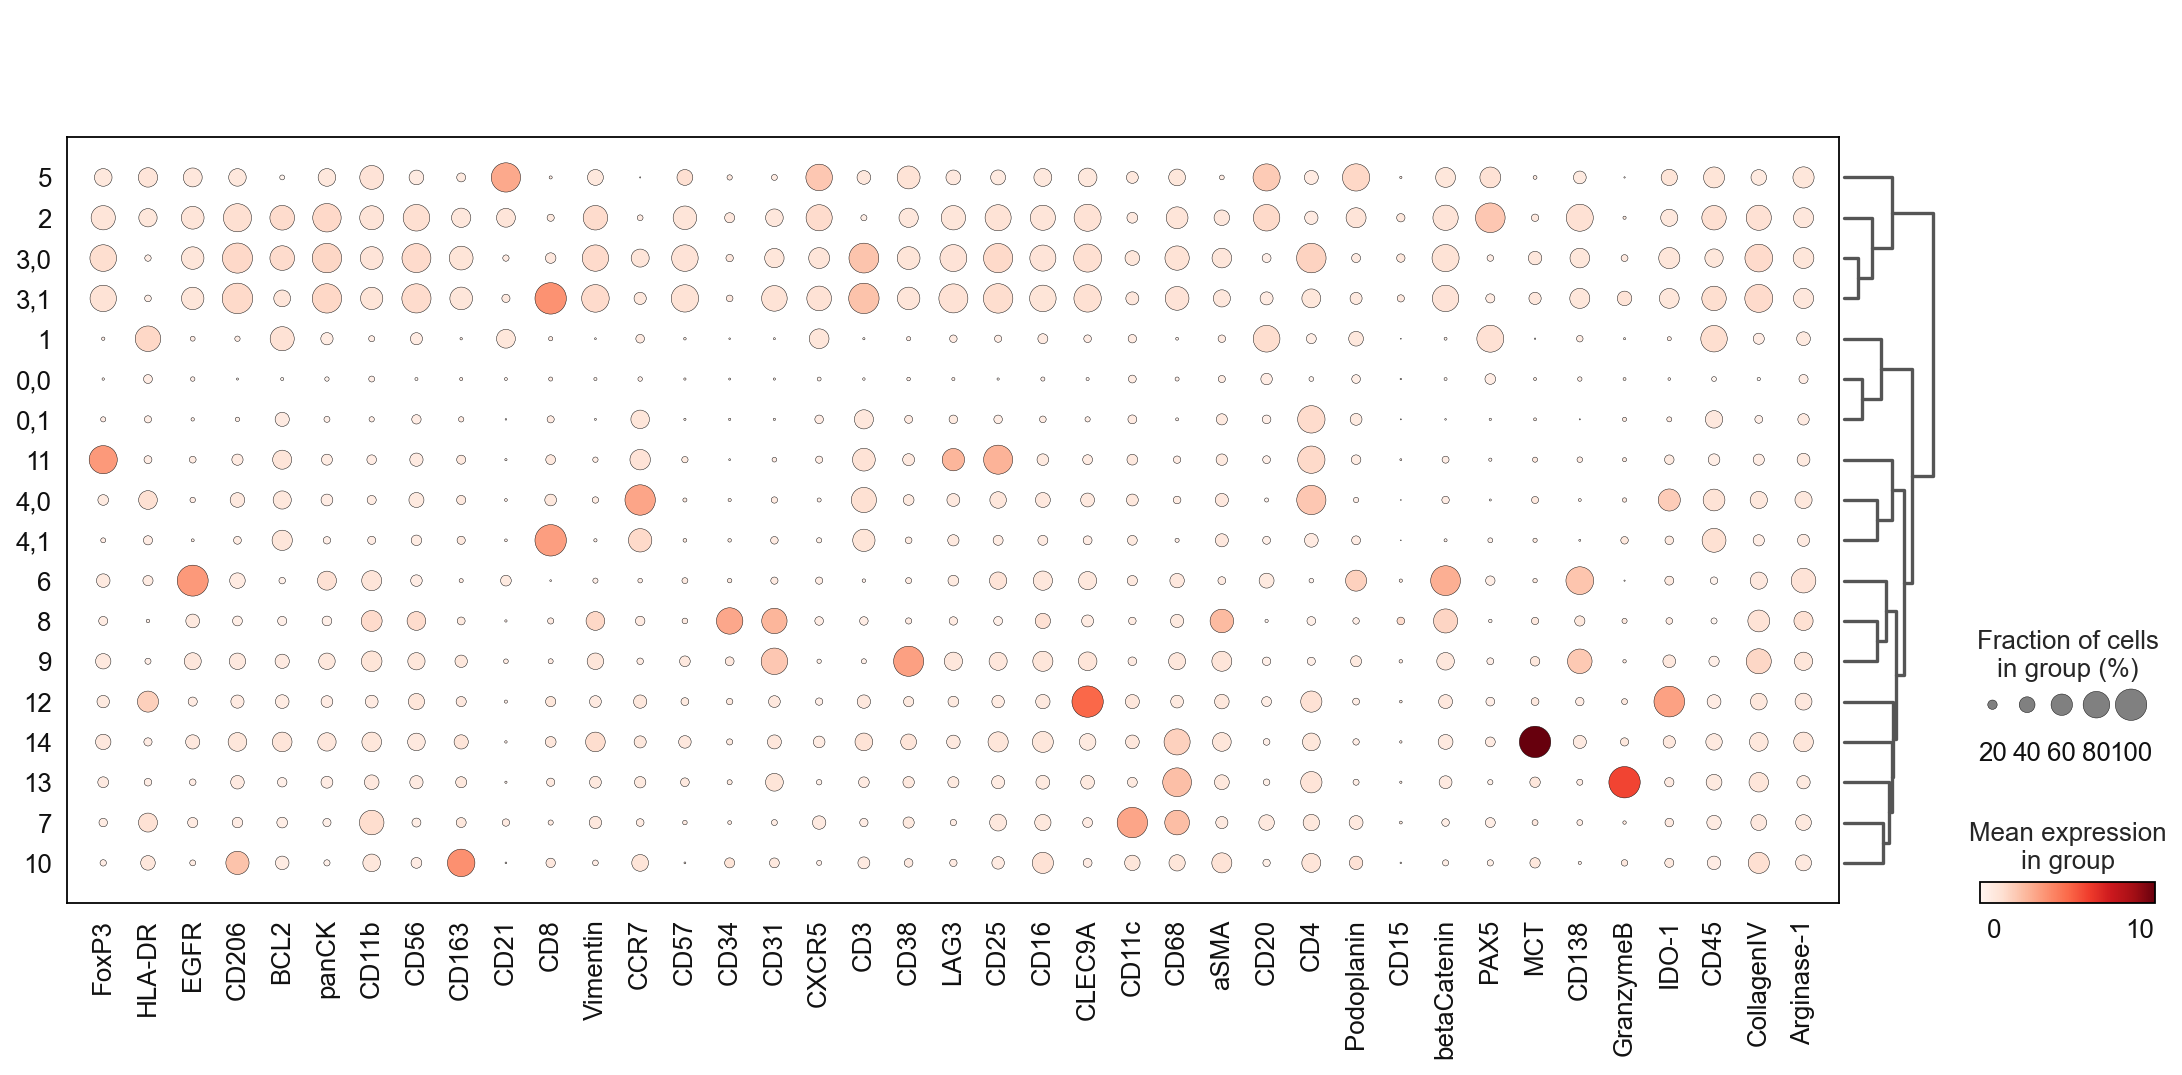

In [8]:
sc.pl.dotplot(adata, marker_list, 'leiden_0.4_subcluster_4', dendrogram=True)

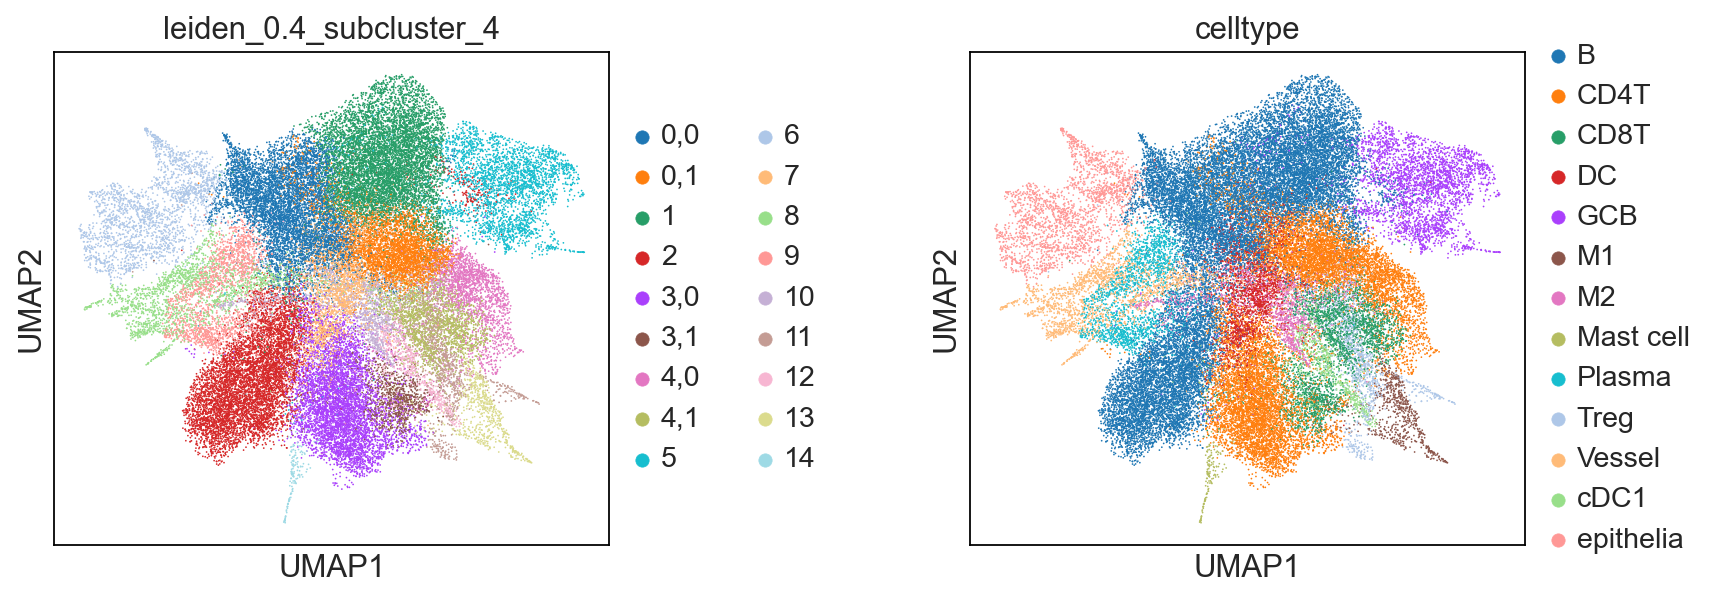

In [9]:
# annotate the clusters based on marker gene expression
# ML annotation of clusters is coming up
cluster_to_ct_dict = {
    '0,0': 'B',
    '0,1': 'CD4T',
    '1': 'B',
    '2':'B',
    '3,0': 'CD4T',
    '3,1': 'CD8T',
    '4,0': 'CD4T',
    '4,1': 'CD8T',
    '5': 'GCB',
    '6': 'epithelia',
    '7': 'DC',
    '8': 'Vessel',
    '9': 'Plasma',
    '10': 'M2',
    '11': 'Treg',
    '12': 'cDC1',
    '13': 'M1',
    '14':'Mast cell'
}
adata.obs['celltype'] = (
    adata.obs['leiden_0.4_subcluster_4']
    .map(cluster_to_ct_dict)
    .astype('category')
)

# just to check if the celltype conversion is successful
sc.pl.umap(adata, color = ['leiden_0.4_subcluster_4', 'celltype'], wspace = 0.5)

### Round 2 subclustering

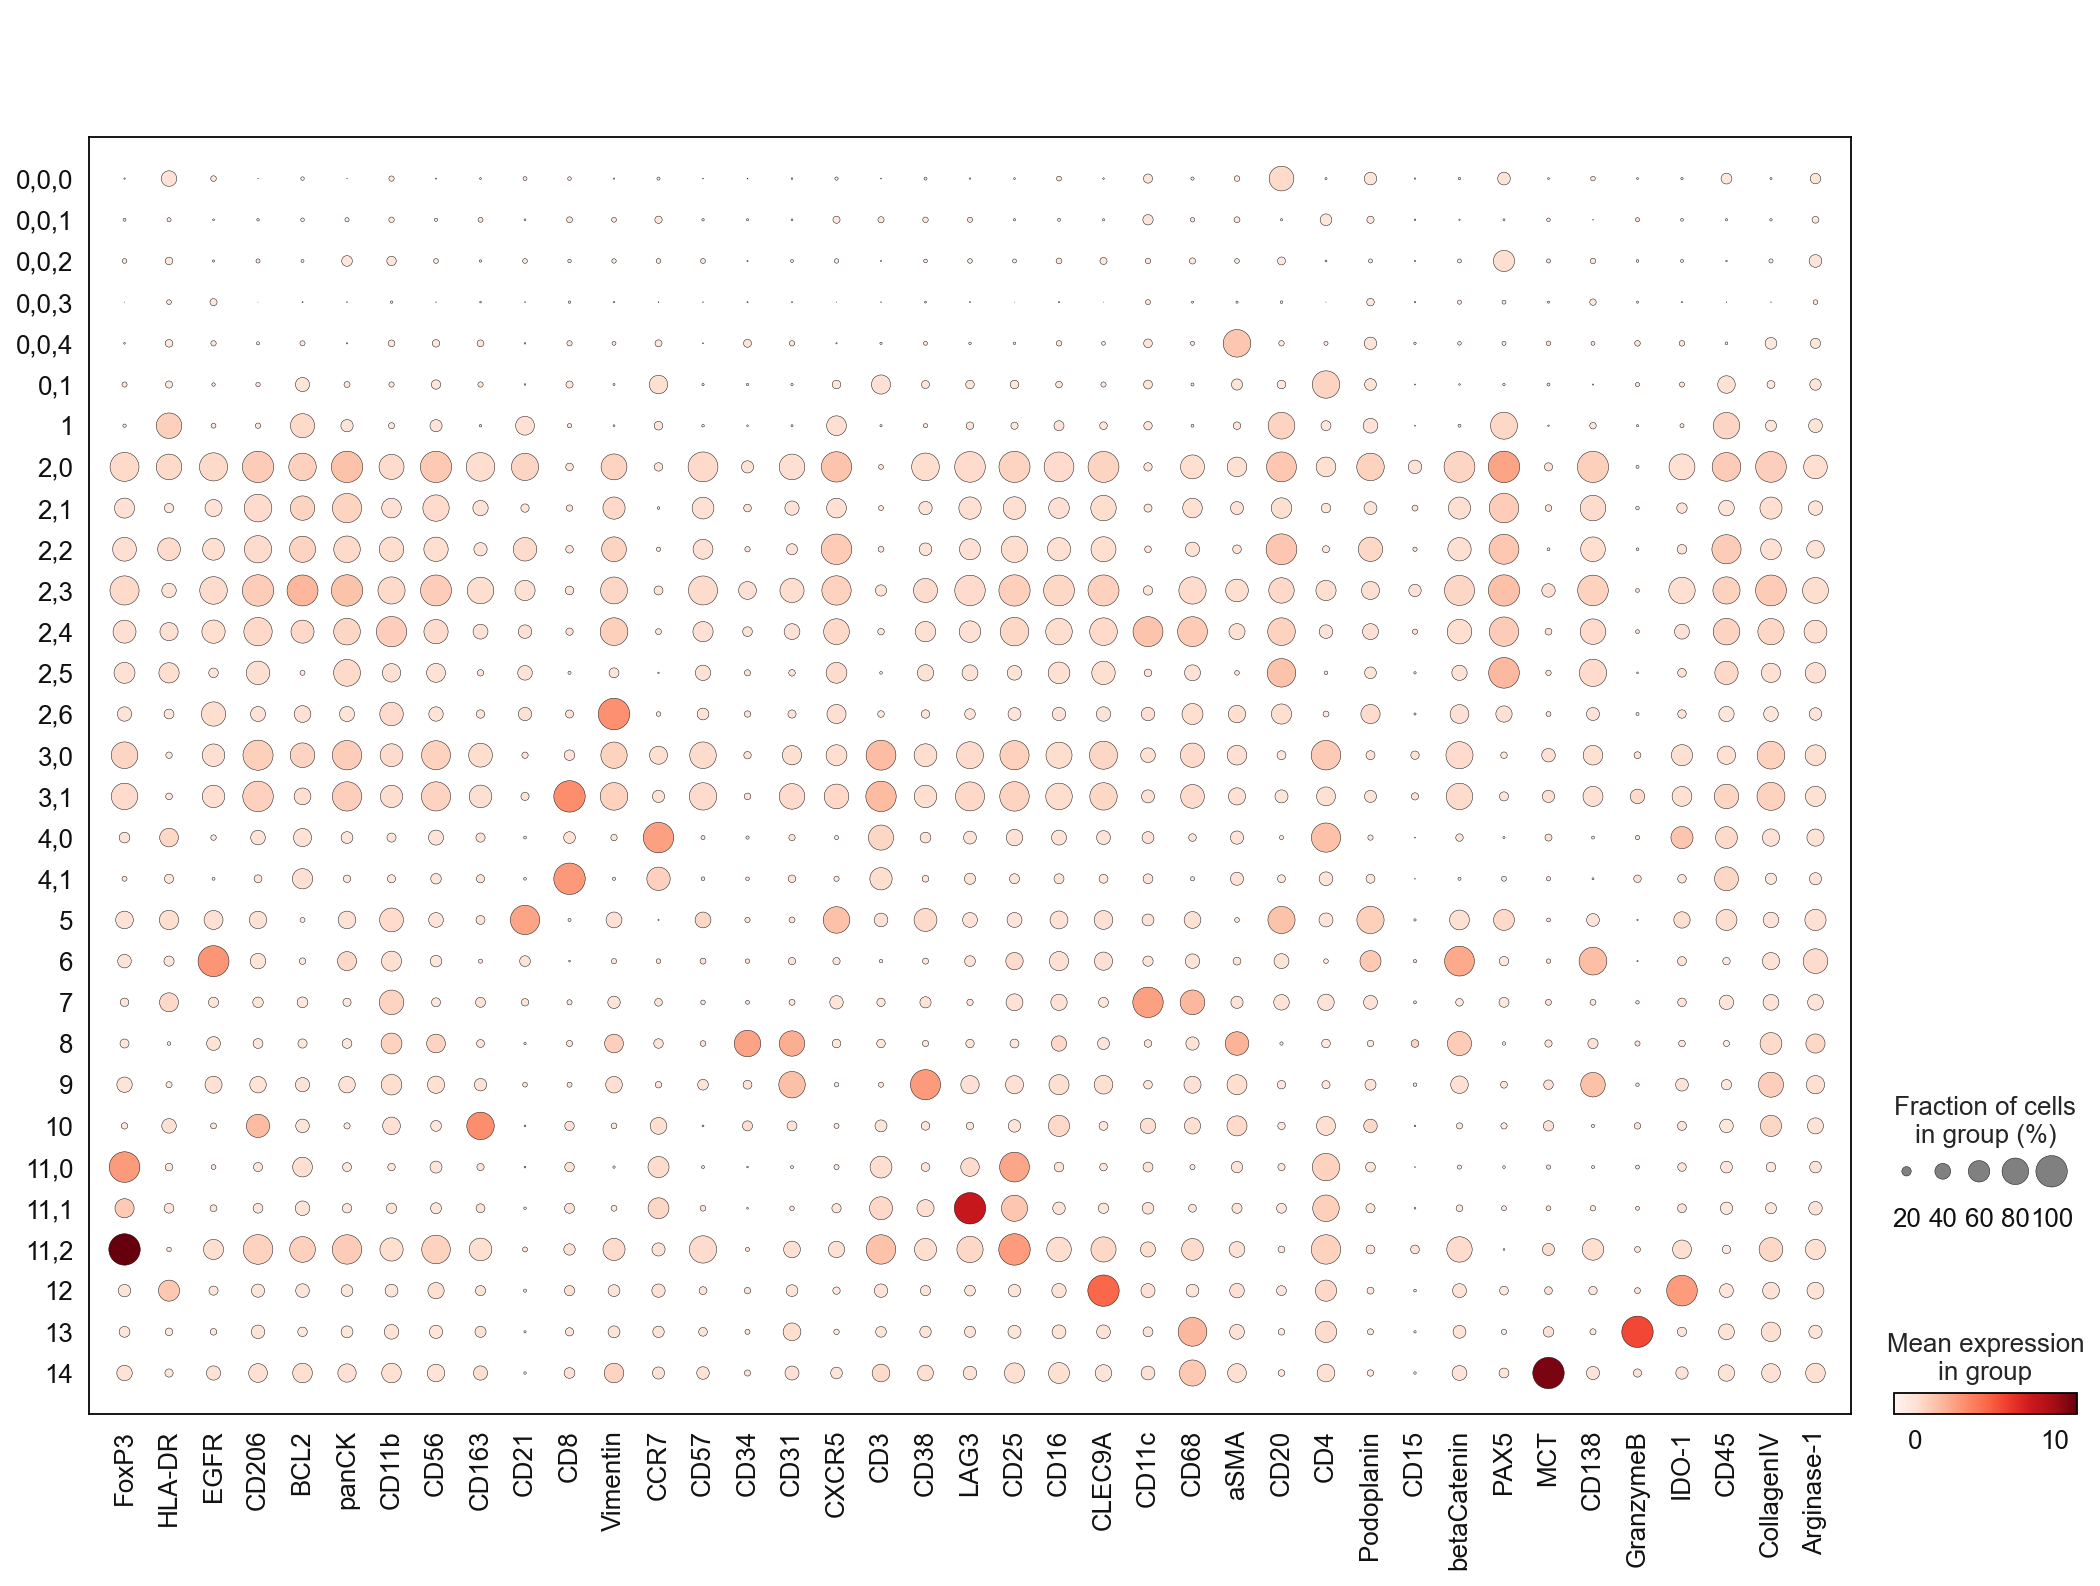

In [10]:
## subclustering cluster 0, 3, 4 sequentially (could be optional for your own data)
sc.tl.leiden(adata, restrict_to=('leiden_0.4_subcluster_4',['2']), resolution=0.4, key_added='leiden_0.4_subcluster_2') # 2,4 DC; 2,0 B
sc.tl.leiden(adata, restrict_to=('leiden_0.4_subcluster_2',['11']), resolution=0.1, key_added='leiden_0.4_subcluster_11')
sc.tl.leiden(adata, restrict_to=('leiden_0.4_subcluster_11',['0,0']), resolution=0.4, key_added='leiden_0.4_subcluster_0sub') #0,0,3 noise, 0,0,1 CD4T, 0.0,4 vessel
sc.pl.dotplot(adata, marker_list, 'leiden_0.4_subcluster_0sub')

## 3.4 Annotate cell types

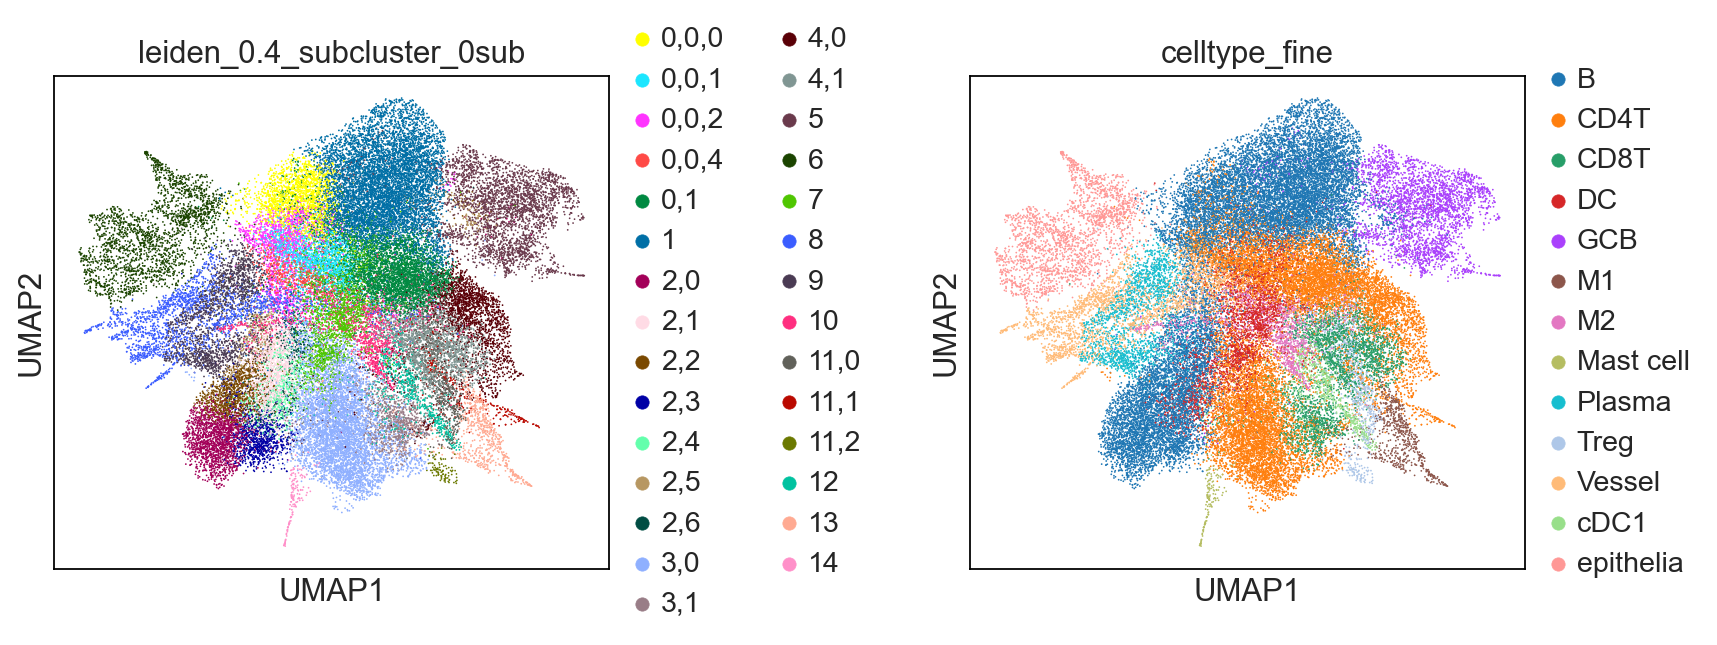

In [11]:
# annotate the clusters based on marker gene expression
# ML annotation of clusters is coming up
cluster_to_ct_dict = {
    '0,0,0': 'B',
    '0,0,1': 'CD4T',
    '0,0,2': 'B',
    '0,0,3': 'noise',  
    '0,0,4': 'Vessel',
    '0,1': 'CD4T',
    '1': 'B',
    '2,0': 'B',
    '2,1': 'B',
    '2,2': 'B',
    '2,3': 'B',
    '2,4': 'DC',
    '2,5': 'B',
    '2,6': 'B',
    '3,0': 'CD4T',
    '3,1': 'CD8T',
    '4,0': 'CD4T',
    '4,1': 'CD8T',
    '5': 'GCB',
    '6': 'epithelia',
    '7': 'DC',
    '8': 'Vessel',
    '9': 'Plasma',
    '10': 'M2',
    '11,0': 'Treg',
    '11,1': 'CD4T',
    '11,2': 'Treg',
    '12': 'cDC1',
    '13': 'M1',
    '14':'Mast cell'
}
adata.obs['celltype_fine'] = (
    adata.obs['leiden_0.4_subcluster_0sub']
    .map(cluster_to_ct_dict)
    .astype('category')
)

# remove noise cell here
adata = adata[ adata.obs['celltype_fine'] != 'noise']

# just to check if the celltype conversion is successful
sc.pl.umap(adata, color = ['leiden_0.4_subcluster_0sub', 'celltype_fine'], wspace = 0.5)

### 3.4 Save AnnData

In [12]:
adata.write(output_dir + "adata_nn_demo_annotated.h5ad")

## 3.5 Single-cell visualzation

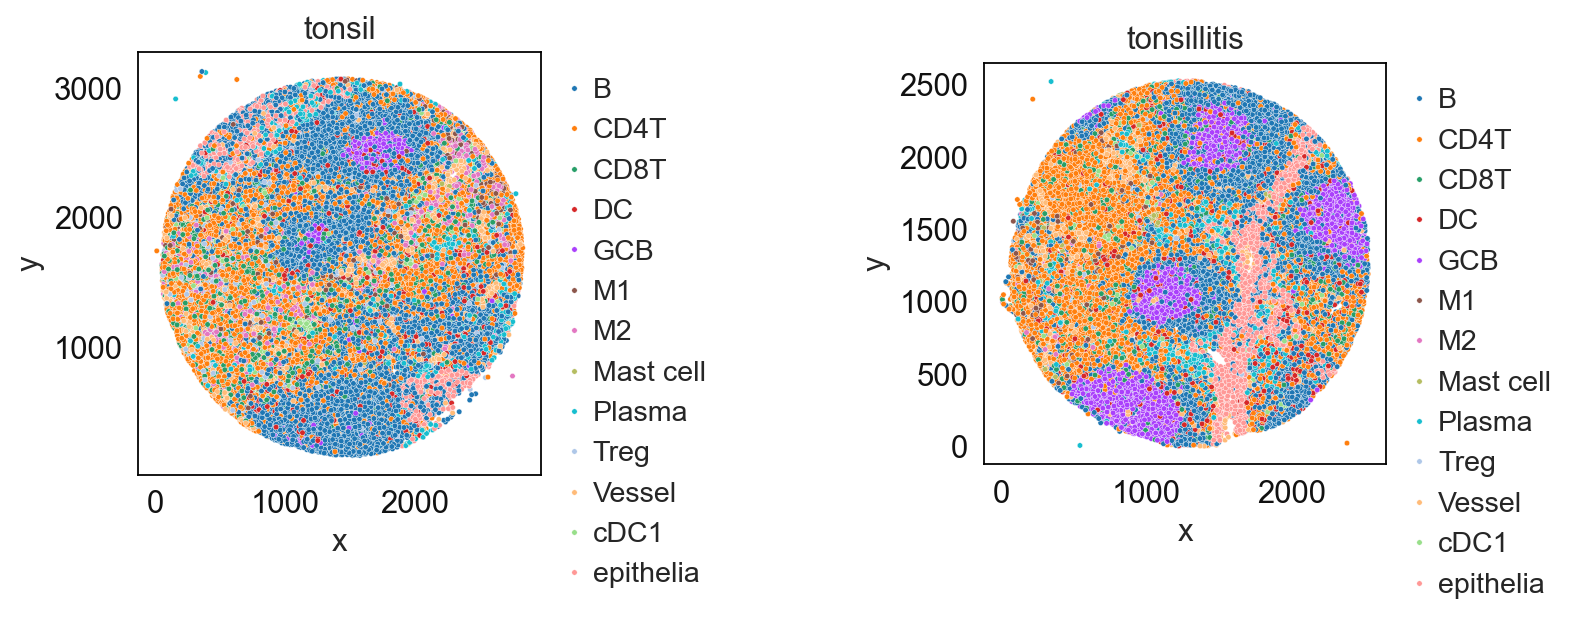

In [13]:
pl_catplot_ad(adata, color = "celltype_fine", # specify group column name here (e.g. celltype_fine)
               unique_region = "condition", # specify unique_regions here
               X='x', Y='y', # specify x and y columns here
               n_columns=2, # adjust the number of columns for plotting here (how many plots do you want in one row?)
               palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
               savefig=False, # save figure as pdf
               output_fname = "", # change it to file name you prefer when saving the figure
               output_dir=output_dir, # specify output directory here (if savefig=True)
             )

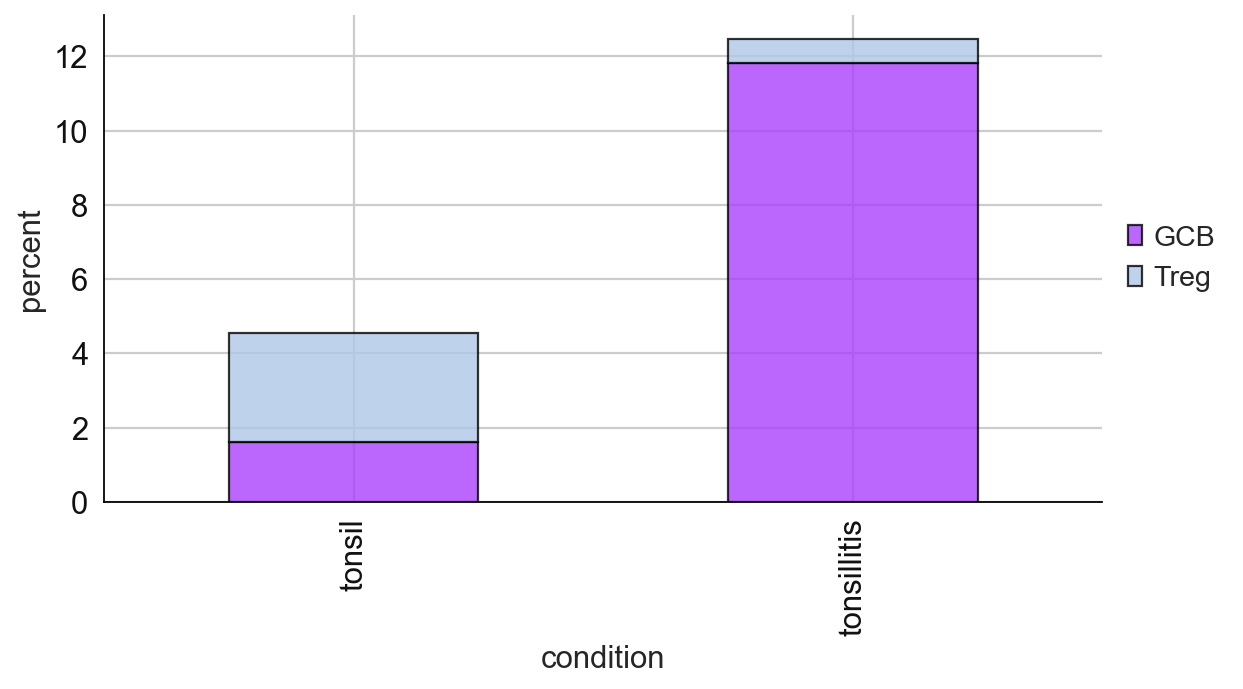

In [14]:
# cell type percentage tab and visualization [much few]
ct_perc_tab, _ = pl_stacked_bar_plot_ad(adata = adata, # adata object to use 
                      color = 'celltype_fine', # column containing the categories that are used to fill the bar plot
                      grouping = 'condition', # column containing a grouping variable (usually a condition or cell group) 
                      cell_list = ['GCB', 'Treg'],  # list of cell types to plot, you can also see the entire cell types adata.obs['celltype_fine'].unique()
                      palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
                      savefig=False, # change it to true if you want to save the figure
                      output_fname = "", # change it to file name you prefer when saving the figure
                      output_dir = output_dir, #output directory for the figure
                      norm = False # if True, then whatever plotted will be scaled to sum of 1
                    ) 

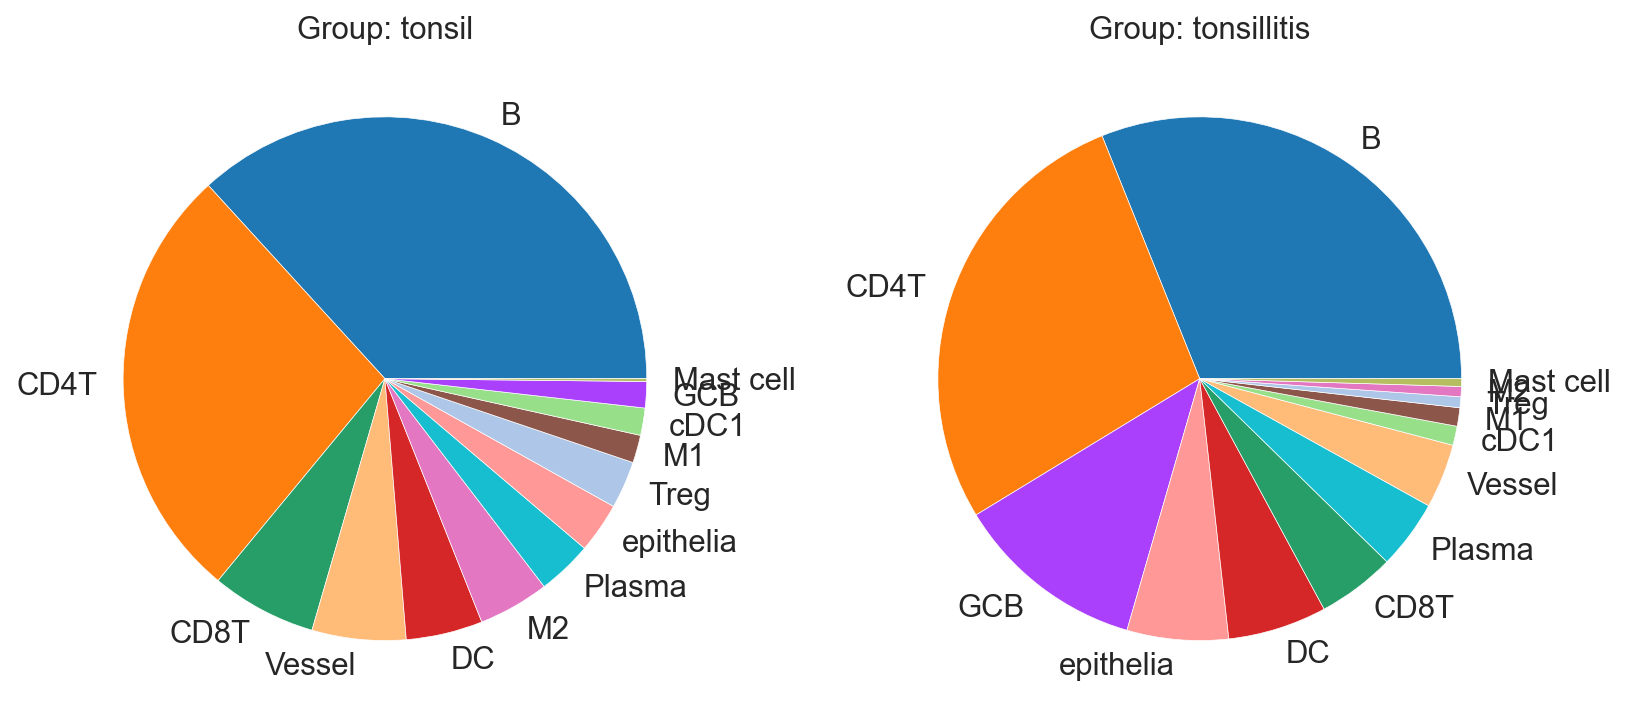

In [15]:
pl_create_pie_charts_ad(adata,
                        color = "celltype_fine", 
                        grouping = "condition", 
                        show_percentages=False,
                        palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
                        savefig=False, # change it to true if you want to save the figure
                        output_fname = "", # change it to file name you prefer when saving the figure
                        output_dir = output_dir #output directory for the figure
                       )

## Additional visualization

In [16]:
# One can also use tissuemap to visualize the cell location in original CODEX space and create tissue based annotation
df = pd.DataFrame(adata.obs) #make sure there are x and y in the dataframe
df.to_csv(output_dir + "adata_nn_demo_annotated.csv")